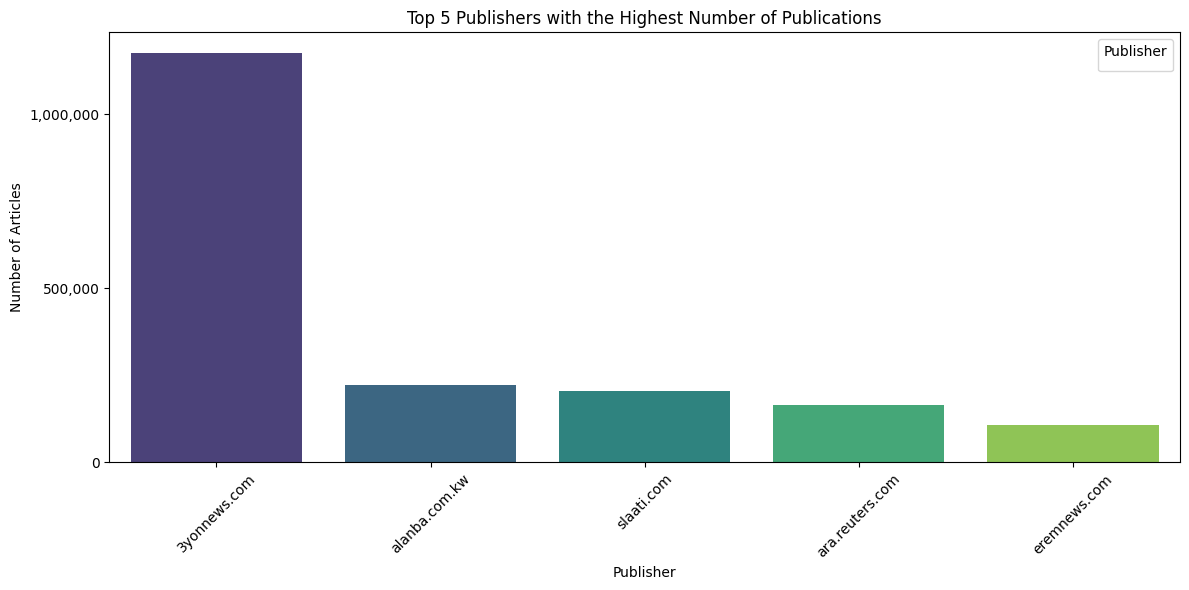

In [31]:
from pyflink.table import EnvironmentSettings, TableEnvironment
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the environment for PyFlink
env_settings = EnvironmentSettings.new_instance().in_batch_mode().build()
table_env = TableEnvironment.create(env_settings)

# Define the paths to the CSV files
file_paths = [
    r"D:\arabic_ccnews_partial (1).csv",
    r"D:\arabic_ccnews_partial (2).csv",
    r"D:\arabic_ccnews_partial.csv",
    r"D:\cleaned_arabic_ccnews_partial.csv",  # Include the cleaned file
]

# Create a temporary table for each CSV file
for path in file_paths:
    # Drop the existing table if it exists
    table_env.execute_sql("DROP TABLE IF EXISTS temp_table")

    # Create a new temporary table with only the necessary columns
    table_env.execute_sql(f"""
        CREATE TABLE temp_table (
            published_date STRING,
            publisher STRING
        ) WITH (
            'connector' = 'filesystem',
            'path' = '{path}',
            'format' = 'csv',
            'csv.ignore-parse-errors' = 'true',
            'csv.field-delimiter' = ','
        )
    """)

# Create a view for easy querying
table_env.execute_sql("CREATE VIEW all_data AS SELECT published_date, publisher FROM temp_table")

# Perform the aggregation to count articles per publisher
result_table = table_env.sql_query("""
    SELECT publisher, COUNT(*) AS number_of_articles
    FROM all_data
    GROUP BY publisher
    ORDER BY number_of_articles DESC
    LIMIT 5  -- Top 5 publishers
""")

# Convert the result table to a Pandas DataFrame
result_df = result_table.to_pandas()

# Check if the DataFrame is empty before plotting
if result_df.empty:
    print("No data to plot. Please check the input data and query.")
else:
    # Plotting the results using seaborn and matplotlib
    plt.figure(figsize=(12, 6))
    bar_plot = sns.barplot(data=result_df, x='publisher', y='number_of_articles', hue='publisher', palette='viridis', legend=False)
    
    # Create custom legend
    handles, labels = bar_plot.get_legend_handles_labels()
    unique_labels = result_df['publisher'].unique()
    custom_handles = [handles[i] for i in range(len(labels)) if labels[i] in unique_labels]
    plt.legend(custom_handles, unique_labels, title='Publisher', loc='upper right')
    
    plt.title('Top 5 Publishers with the Highest Number of Publications')
    plt.xlabel('Publisher')
    plt.ylabel('Number of Articles')
    plt.xticks(rotation=45)
    plt.yticks(range(0, int(result_df['number_of_articles'].max()) + 1, 500000), 
               [f"{i:,d}" for i in range(0, int(result_df['number_of_articles'].max()) + 1, 500000)])
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()


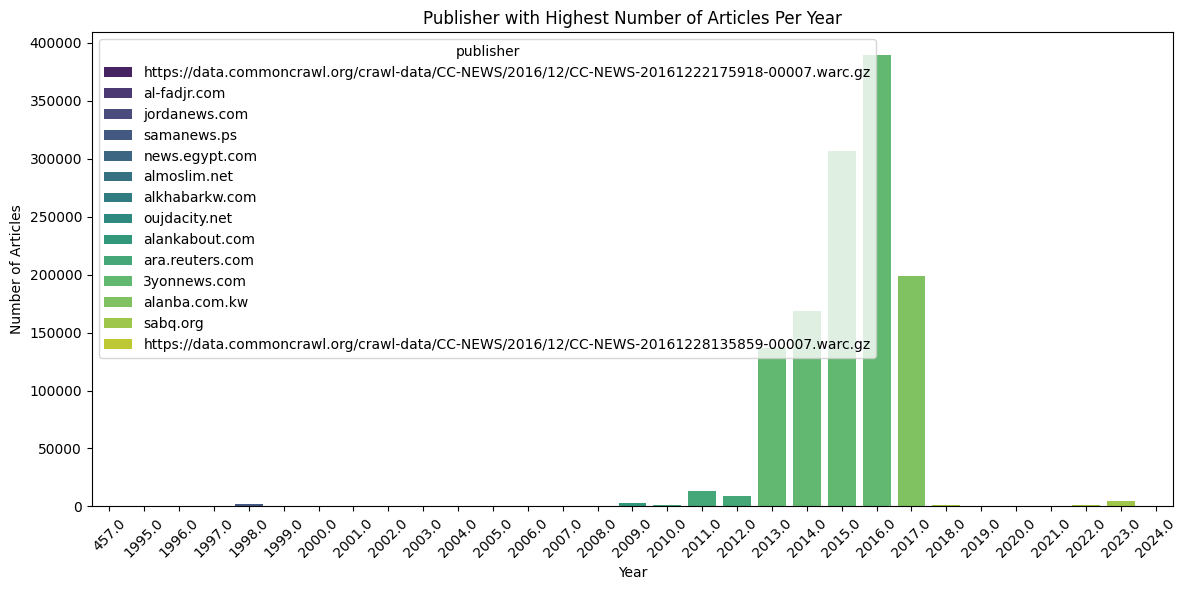

In [32]:
from pyflink.table import EnvironmentSettings, TableEnvironment
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the environment for PyFlink
env_settings = EnvironmentSettings.new_instance().in_batch_mode().build()
table_env = TableEnvironment.create(env_settings)

# Define the paths to the CSV files, including all specified files
file_paths = [
    r"D:\arabic_ccnews_partial (1).csv",
    r"D:\arabic_ccnews_partial (2).csv",
    r"D:\arabic_ccnews_partial.csv",
    r"D:\cleaned_arabic_ccnews_partial.csv",  # Ensure this is the correct path for your cleaned file
]

# Create a temporary table for each CSV file
for i, path in enumerate(file_paths):
    table_name = f"temp_table_{i}"
    
    # Drop the existing table if it exists
    table_env.execute_sql(f"DROP TABLE IF EXISTS {table_name}")
    
    # Create a new temporary table for each CSV file with only the desired columns
    table_env.execute_sql(f"""
        CREATE TABLE {table_name} (
            published_date STRING,
            publisher STRING
        ) WITH (
            'connector' = 'filesystem',
            'path' = '{path}',
            'format' = 'csv',
            'csv.ignore-parse-errors' = 'true',  -- Ignore lines with parse errors
            'csv.field-delimiter' = ','           -- Ensure correct delimiter
        )
    """)

# Create a view for easy querying across all temp tables
table_env.execute_sql("DROP VIEW IF EXISTS all_data")
if len(file_paths) > 0:
    union_queries = " UNION ALL ".join(
        [f"SELECT published_date, publisher FROM temp_table_{i}" for i in range(len(file_paths))]
    )
    table_env.execute_sql(f"""
        CREATE VIEW all_data AS 
        SELECT 
            CAST(YEAR(CAST(TO_DATE(published_date) AS DATE)) AS INT) AS article_year,
            publisher
        FROM (
            {union_queries}
        )
        WHERE published_date IS NOT NULL  -- Ensure published_date is not null
    """)

# Create a table to get the maximum articles per year per publisher
max_articles_per_year_table = table_env.sql_query("""
    SELECT 
        article_year,
        publisher,
        COUNT(*) AS article_count,
        ROW_NUMBER() OVER (PARTITION BY article_year ORDER BY COUNT(*) DESC) AS row_num
    FROM all_data
    GROUP BY article_year, publisher
    HAVING publisher IS NOT NULL  -- Ensure publisher is not null
""")

# Filter to get only the highest articles per year
max_articles_per_year_table = table_env.sql_query("""
    SELECT article_year, publisher, article_count
    FROM (
        SELECT 
            article_year,
            publisher,
            COUNT(*) AS article_count,
            ROW_NUMBER() OVER (PARTITION BY article_year ORDER BY COUNT(*) DESC) AS row_num
        FROM all_data
        GROUP BY article_year, publisher
        HAVING publisher IS NOT NULL  -- Ensure publisher is not null
    ) AS ranked_articles  -- Added alias for the inner query
    WHERE row_num = 1
""")

# Convert the result table to a Pandas DataFrame
result_df = max_articles_per_year_table.to_pandas()

# Plotting the results using seaborn and matplotlib
plt.figure(figsize=(12, 6))
sns.barplot(data=result_df, x='article_year', y='article_count', hue='publisher', palette='viridis')
plt.title('Publisher with Highest Number of Articles Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


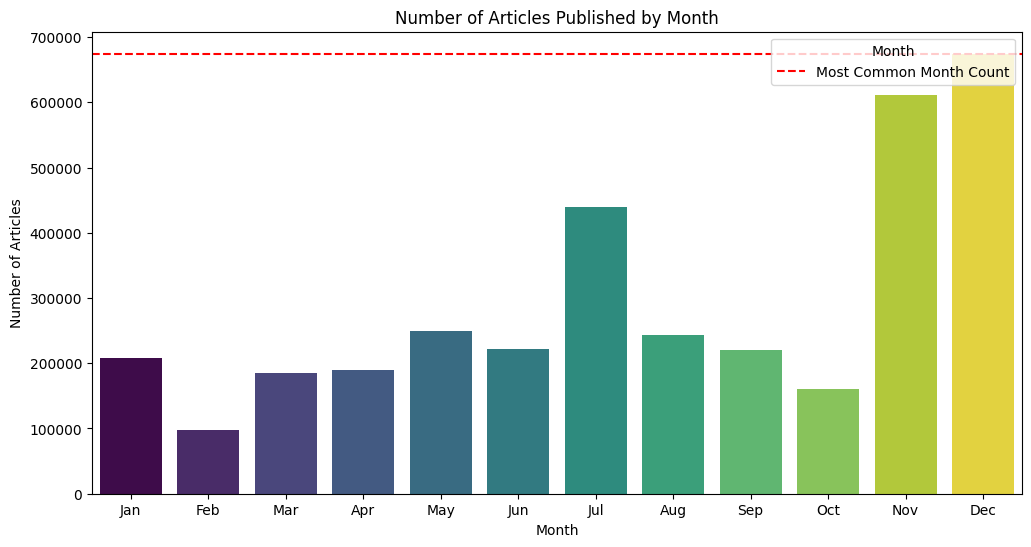

In [19]:
from pyflink.table import EnvironmentSettings, TableEnvironment
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the environment for PyFlink
env_settings = EnvironmentSettings.new_instance().in_batch_mode().build()
table_env = TableEnvironment.create(env_settings)

# Define the paths to the CSV files
file_paths = [
    r"D:\arabic_ccnews_partial (1).csv",
    r"D:\arabic_ccnews_partial (2).csv",
    r"D:\arabic_ccnews_partial.csv",
    r"D:\cleaned_arabic_ccnews_partial.csv",  # Include the new file
]

# Create a temporary table for each CSV file
for i, path in enumerate(file_paths):
    table_name = f"temp_table_{i}"
    
    # Drop the existing table if it exists
    table_env.execute_sql(f"DROP TABLE IF EXISTS {table_name}")
    
    # Create a new temporary table for each CSV file with only the necessary columns
    table_env.execute_sql(f"""
        CREATE TABLE {table_name} (
            published_date STRING,
            publisher STRING
        ) WITH (
            'connector' = 'filesystem',
            'path' = '{path}',
            'format' = 'csv',
            'csv.ignore-parse-errors' = 'true',
            'csv.field-delimiter' = ','
        )
    """)

# Combine the queries without creating a view, selecting only the needed columns
result_table = table_env.sql_query(f"""
    SELECT 
        EXTRACT(MONTH FROM TO_DATE(published_date, 'yyyy-MM-dd')) AS month_num,
        COUNT(*) AS article_count
    FROM (
        SELECT published_date, publisher FROM temp_table_0
        UNION ALL
        SELECT published_date, publisher FROM temp_table_1
        UNION ALL
        SELECT published_date, publisher FROM temp_table_2
        UNION ALL
        SELECT published_date, publisher FROM temp_table_3  -- Include the cleaned file
    ) AS combined
    WHERE published_date IS NOT NULL  -- Ensure published_date is not null
    GROUP BY EXTRACT(MONTH FROM TO_DATE(published_date, 'yyyy-MM-dd'))
    ORDER BY month_num
""")

# Convert the result table to a Pandas DataFrame
result_df = result_table.to_pandas()

# Check if the DataFrame is empty before proceeding
if result_df.empty:
    print("No data to plot. Please check the input data and query.")
else:
    # Determine the most common month
    most_common_month = result_df.loc[result_df['article_count'].idxmax()]

    # Plotting the results with colors and addressing the warning
    plt.figure(figsize=(12, 6))
    sns.barplot(data=result_df, x='month_num', y='article_count', hue='month_num', palette='viridis', legend=False)
    plt.title('Number of Articles Published by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Articles')
    plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.axhline(most_common_month['article_count'], color='red', linestyle='--', label='Most Common Month Count')
    plt.legend(title='Month', loc='upper right')
    plt.show()
